LSTM

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F
import math
import random
import re
import collections

d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  
    """Load the time machine dataset into a list of text lines."""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def tokenize(lines, token='word'): 
    """Split text into word and character"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('error: unknown token: ' + token)

def count_corpus(tokens):
    """Statistics frequency of labels"""
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

class Vocab:
    """Text vocabulary"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [
            token for token, freq in self.token_freqs
            if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def seq_data_iter_random(corpus, batch_size, num_steps):
    """Use random sampling to generate mini batch"""
    corpus = corpus[random.randint(0, num_steps - 1):]
    num_subseqs = (len(corpus) - 1) // num_steps
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    random.shuffle(initial_indices)

    def data(pos):
        return corpus[pos:pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Use order to generate mini batch sequence"""
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset:offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1:offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y

def load_corpus_time_machine(max_tokens=-1):
    """Return label index and vocabulary of time machine dataset"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

class SeqDataLoader:
    """Load data iterator of sequence data"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps,  
                           use_random_iter=False, max_tokens=10000):
    """Return iterator and vocabulary of time machine dataset"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter,
                              max_tokens)
    return data_iter, data_iter.vocab

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)
    
def predict_ch8(prefix, num_preds, net, vocab, device):
    """Generate new word or character after prefix"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

def grad_clipping(net, theta):
    """Gradient clipping"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad() # Reset gradient back to zero
            l.backward() # Compute gradient
            grad_clipping(net, 1) # Gradient clipping
            updater.step() # Update gradient
        else:
            l.backward() # Compute gradient
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0: # Every 10 epochs
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} label/second {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        if not self.rnn.bidirectional: # Single direction
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else: # Bi-direction
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens), device=device) # RNN / LSTM single direction
        else:
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device),
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)) # Bi-direction

# Initialization of LSTM parameters
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size # Input size = Output size = Vocab size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01 # Small scale 0.01

    def three(): # Initialization of weight and bias
        return (
            normal((num_inputs, num_hiddens)), 
            normal((num_hiddens, num_hiddens)),
            torch.zeros(num_hiddens, device=device)
        )
    
    """
    Forget gate F: decrease values towards zero
    Input gate I: decide to ignore input data or not
    Output gate O: decide to use hidden states or not
    """

    W_xi, W_hi, b_i = three() # Input gate I
    W_xf, W_hf, b_f = three() # Forget gate F
    W_xo, W_ho, b_o = three() # Output gate O
    W_xc, W_hc, b_c = three() # Memory unit C
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q
    ]
    for param in params:
        param.requires_grad_(True)
    return params

In [2]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (
        torch.zeros((batch_size, num_hiddens), device=device), # Hidden state H
        torch.zeros((batch_size, num_hiddens), device=device)  # Memory unit C
    )

In [3]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        """
        @ matrix multiplication
        * element-wise product
        """
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i) # Input gate I is updated by H from last time step T - 1
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f) # Forget gate F is updated by H from last time step T - 1
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o) # Output gate O is updated by H from last time step T - 1
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c) # Candidate memory unit C_tilda is updated by H from last time step T - 1
        C = F * C + I * C_tilda # Memory unit C is updated by C from last time step T - 1
        H = O * torch.tanh(C) # Hidden state H (current time step T) is updated by O and C from current time step T
        Y = (H @ W_hq) + b_q # Output Y (Linear formula)
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

perplexity 1.2, 16901.2 label/second cuda:0
time traveller smimet yey mubhed ancension of space the i wir th
travellery we can and manistadiman of sughe are wiment frem


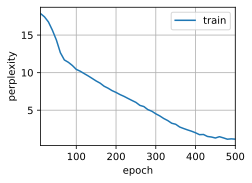

In [4]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
# model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params, init_lstm_state, lstm)
# d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)
model = RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params, init_lstm_state, lstm)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 254430.9 label/second cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller hit fow you trype of the wacceate the frery ufur 


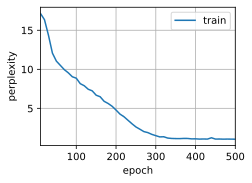

In [5]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
# model = d2l.RNNModel(lstm_layer, len(vocab))
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
# d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)